In [2]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps
from polartoolkit import utils as polar_utils
import string

from invert4geom import inversion, plotting, synthetic, utils

In [3]:
# set grid parameters
spacing = 1e3
inversion_region = [0, 80e3, 0, 60e3]

buffer_region = vd.pad_region(inversion_region, pad=6e3)
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    buffer_region,
)

inversion region =  [0, 80000.0, 0, 60000.0]
buffer region =  (-6000.0, 86000.0, -6000.0, 66000.0)


In [4]:
num_constraints = 30
coords = vd.scatter_points(
    region=vd.pad_region(inversion_region, -2e3), size=num_constraints, random_state=1
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

x_range = abs(inversion_region[0] - inversion_region[1]) / 1000
y_range = abs(inversion_region[2] - inversion_region[3]) / 1000
inversion_area = x_range * y_range

const_density = inversion_area / num_constraints

print(f"inversion region: {inversion_area} km\u00b2")
print(f"constraint density: 1 constraint per {const_density} km\u00b2")
print(f"Ross Ice Shelf constraint density: 1 constraint per {487000 / 224} km\u00b2")

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)
constraint_points.head()

inversion region: 4800.0 km²
constraint density: 1 constraint per 160.0 km²
Ross Ice Shelf constraint density: 1 constraint per 2174.1071428571427 km²


,easting,northing,upward
0,33693.672357,7507.422695,469.360206
1,56744.661502,25582.027000,515.234600
2,2008.692486,55641.813688,652.349330
3,24977.275520,31857.255958,467.788477
4,13153.447702,40745.118381,411.819148


In [5]:
# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-20, 0, 100),
)

In [6]:
# resample to check values are same at constraints
check = utils.sample_grids(
    constraint_points, starting_topography, "sampled", coord_names=("easting", "northing")
)
check["dif"] = check.upward - check.sampled
check.describe()

,easting,northing,upward,sampled,dif
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,35094.036884,28162.392513,455.447246,455.480407,-0.033161
std,23252.729763,16835.840541,91.418033,90.979827,2.245274
min,2008.692486,3024.143531,279.590562,287.884490,-8.293928
25%,15219.277931,14606.034103,412.976608,410.467816,-0.334043
50%,32924.000199,28305.067193,462.264137,461.712137,0.006700
75%,54481.559601,41076.130716,518.755277,518.790409,0.238166
max,75587.879755,57376.220979,652.349330,652.520749,8.074282


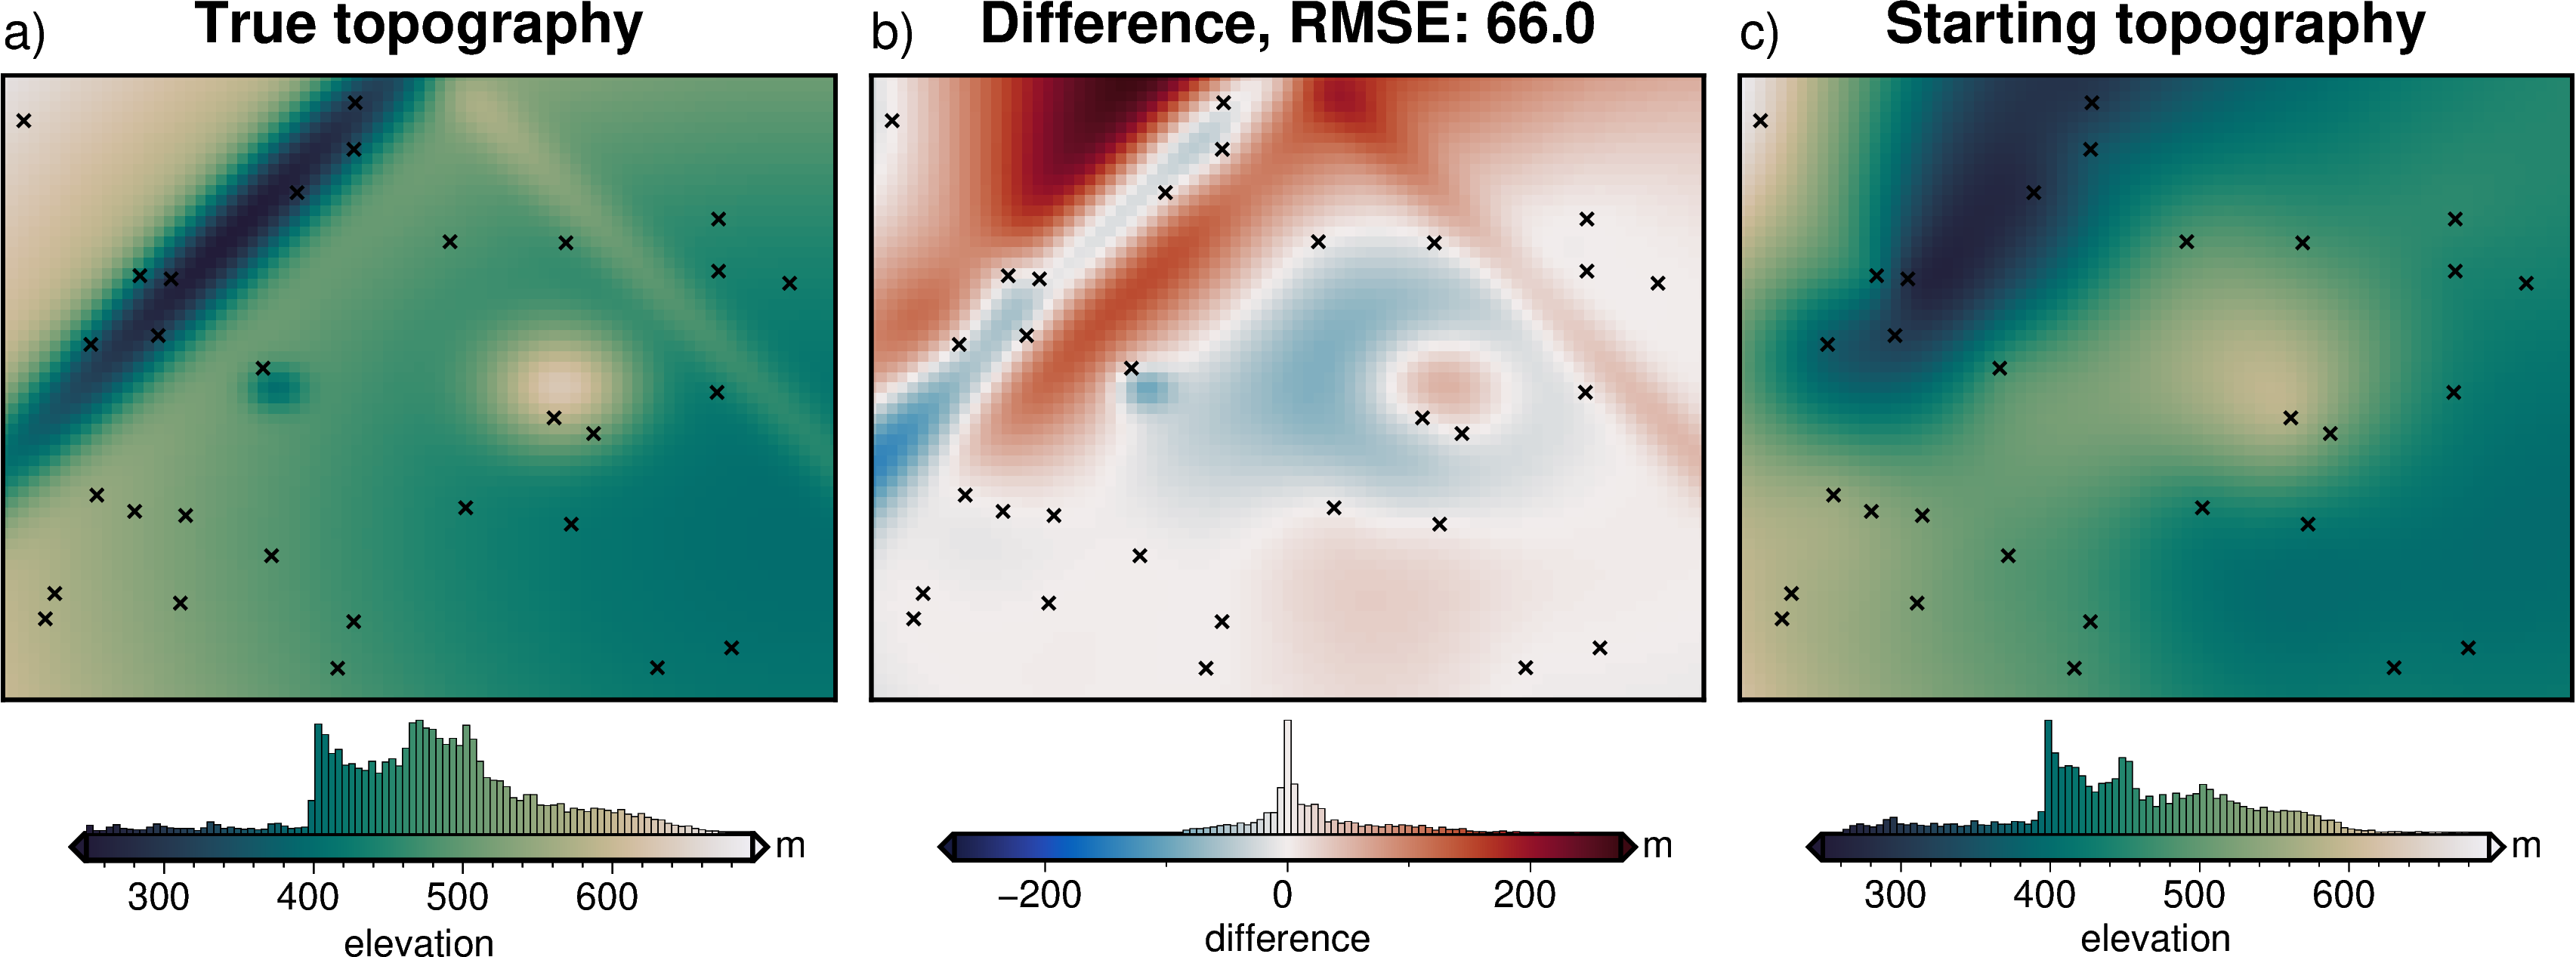

In [7]:
# compare starting and actual layer2 grids
grids = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    fig_height=7,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True topography",
    grid2_name="Starting topography",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
    # show_region=inversion_region,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1.5,
    # robust=True,
    robust=False,
    subplot_labels=True,
    label_font="16p,Helvetica,black",
)

In [8]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
true_zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    true_topography >= true_zref, true_density_contrast, -true_density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    true_zref,
    density=density_grid,
)

In [9]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=inversion_region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["observed_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav
0,0.0,0.0,1000.0,11.830044
1,0.0,1000.0,1000.0,11.410575
2,0.0,2000.0,1000.0,10.983736
3,0.0,3000.0,1000.0,10.553015
4,0.0,4000.0,1000.0,10.120588
...,...,...,...,...
4936,60000.0,76000.0,1000.0,2.079946
4937,60000.0,77000.0,1000.0,2.075750
4938,60000.0,78000.0,1000.0,2.077695
4939,60000.0,79000.0,1000.0,2.085408


In [10]:
# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= true_zref, true_density_contrast, -true_density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    true_zref,
    density=density_grid,
)

grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav,starting_grav
0,0.0,0.0,1000.0,11.830044,13.466523
1,0.0,1000.0,1000.0,11.410575,12.781116
2,0.0,2000.0,1000.0,10.983736,12.113283
3,0.0,3000.0,1000.0,10.553015,11.467299
4,0.0,4000.0,1000.0,10.120588,10.845332
...,...,...,...,...,...
4936,60000.0,76000.0,1000.0,2.079946,-4.791546
4937,60000.0,77000.0,1000.0,2.075750,-4.657442
4938,60000.0,78000.0,1000.0,2.077695,-4.527337
4939,60000.0,79000.0,1000.0,2.085408,-4.399277


gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


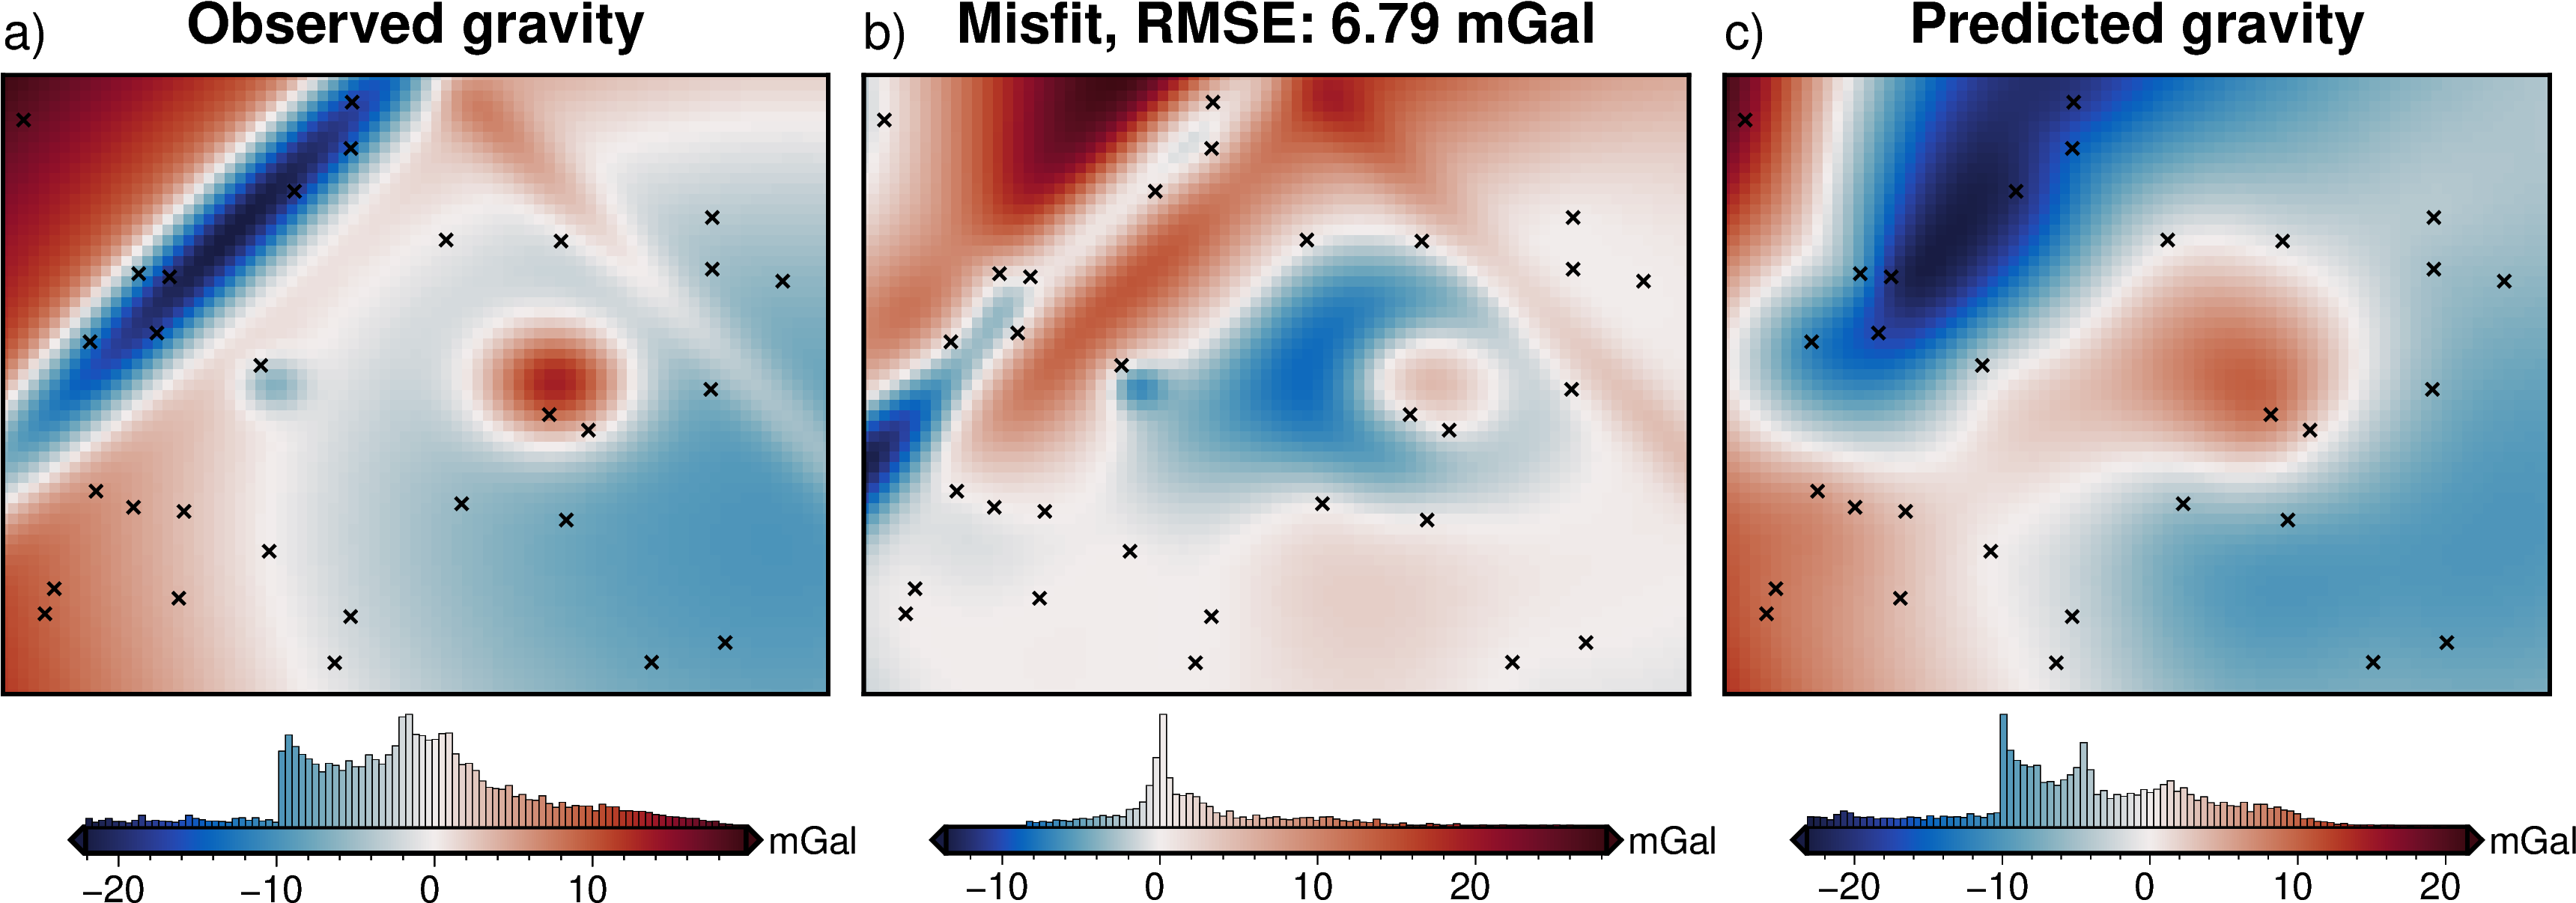

In [11]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

dif = grav_grid.observed_grav - grav_grid.starting_grav
rmse = utils.rmse(dif)

grids = [grav_grid.observed_grav, dif, grav_grid.starting_grav]
titles = [
    "Observed gravity",
    f"Misfit, RMSE: {round(rmse,2)} mGal",
    "Predicted gravity",
]
cmaps = ["balance+h0", "balance+h0", "balance+h0"]
# cmaps = ["vik", "vik+h0", "vik"]
for i, g in enumerate(grids):
    if i == 0:
        fig = None
        origin_shift = "initialize"
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        region=inversion_region,
        fig_height=7,
        cmap=cmaps[i],
        # robust=True,
        title=titles[i],
        cbar_unit="mGal",
        hist=True,
        cbar_yoffset=1.5,
        # grd2cpt=True,
        title_font="18p,Helvetica-bold,black",
        fig=fig,
        origin_shift=origin_shift,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.2c",
        points_pen="1p",
    )
    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[i]})",
        font="16p,Helvetica,black",
        offset="j0/.3",
        no_clip=True,
    )
fig.show()

# Damping Cross Validation

solver_damping values:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:solver_damping value: 0.001 -> Score: 0.2800430254911796
INFO:root:solver_damping value: 0.0021544346900318843 -> Score: 0.22794591218540908
INFO:root:solver_damping value: 0.004641588833612777 -> Score: 0.14475527714233202
INFO:root:solver_damping value: 0.01 -> Score: 0.0450691935785583
INFO:root:solver_damping value: 0.021544346900318832 -> Score: 0.04541439150490599
INFO:root:solver_damping value: 0.046415888336127774 -> Score: 0.046246217876463235
INFO:root:solver_damping value: 0.1 -> Score: 0.046397156069759596
INFO:root:solver_damping value: 0.21544346900318823 -> Score: 0.09113561656672994
INFO:root:solver_damping value: 0.46415888336127775 -> Score: 6.270602291418281
INFO:root:solver_damping value: 1.0 -> Score: 6.63932279720927
INFO:root:Best score of 0.0450691935785583 with solver_damping=0.01
INFO:root:Damping CV finished with best value found of 0.01. Using this value with the zref/density CV.


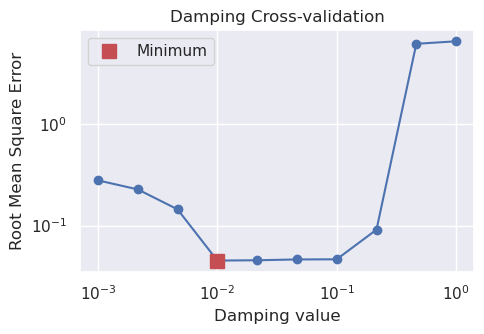

In [12]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "starting_prisms": starting_prisms,
    "grav_data_column": "observed_grav",
    "deriv_type": "annulus",
    # set stopping criteria
    "max_iterations": 100,
    "l2_norm_tolerance": 0.05,
    "delta_l2_norm_tolerance": 1.02,
    # for creating test/train splits
    "grav_spacing":spacing,
    "inversion_region":inversion_region,
    # for calculating the regional component of misfit
    "regional_grav_kwargs": {
        "regional_method": "constant",
        "constant": 0,
    },
}

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    calculate_gravity_misfit=True,
    calculate_regional_misfit=True,
    run_damping_cv=True,
    damping_values=np.logspace(-3, 0, 10),
    plot_cv=True,
    cv_progressbar=True,
    fname="../../results/simple_damping_cv",
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [ ]:
# load saved inversion results
with pathlib.Path("../../results/simple_damping_cv").open("rb") as f:
    results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

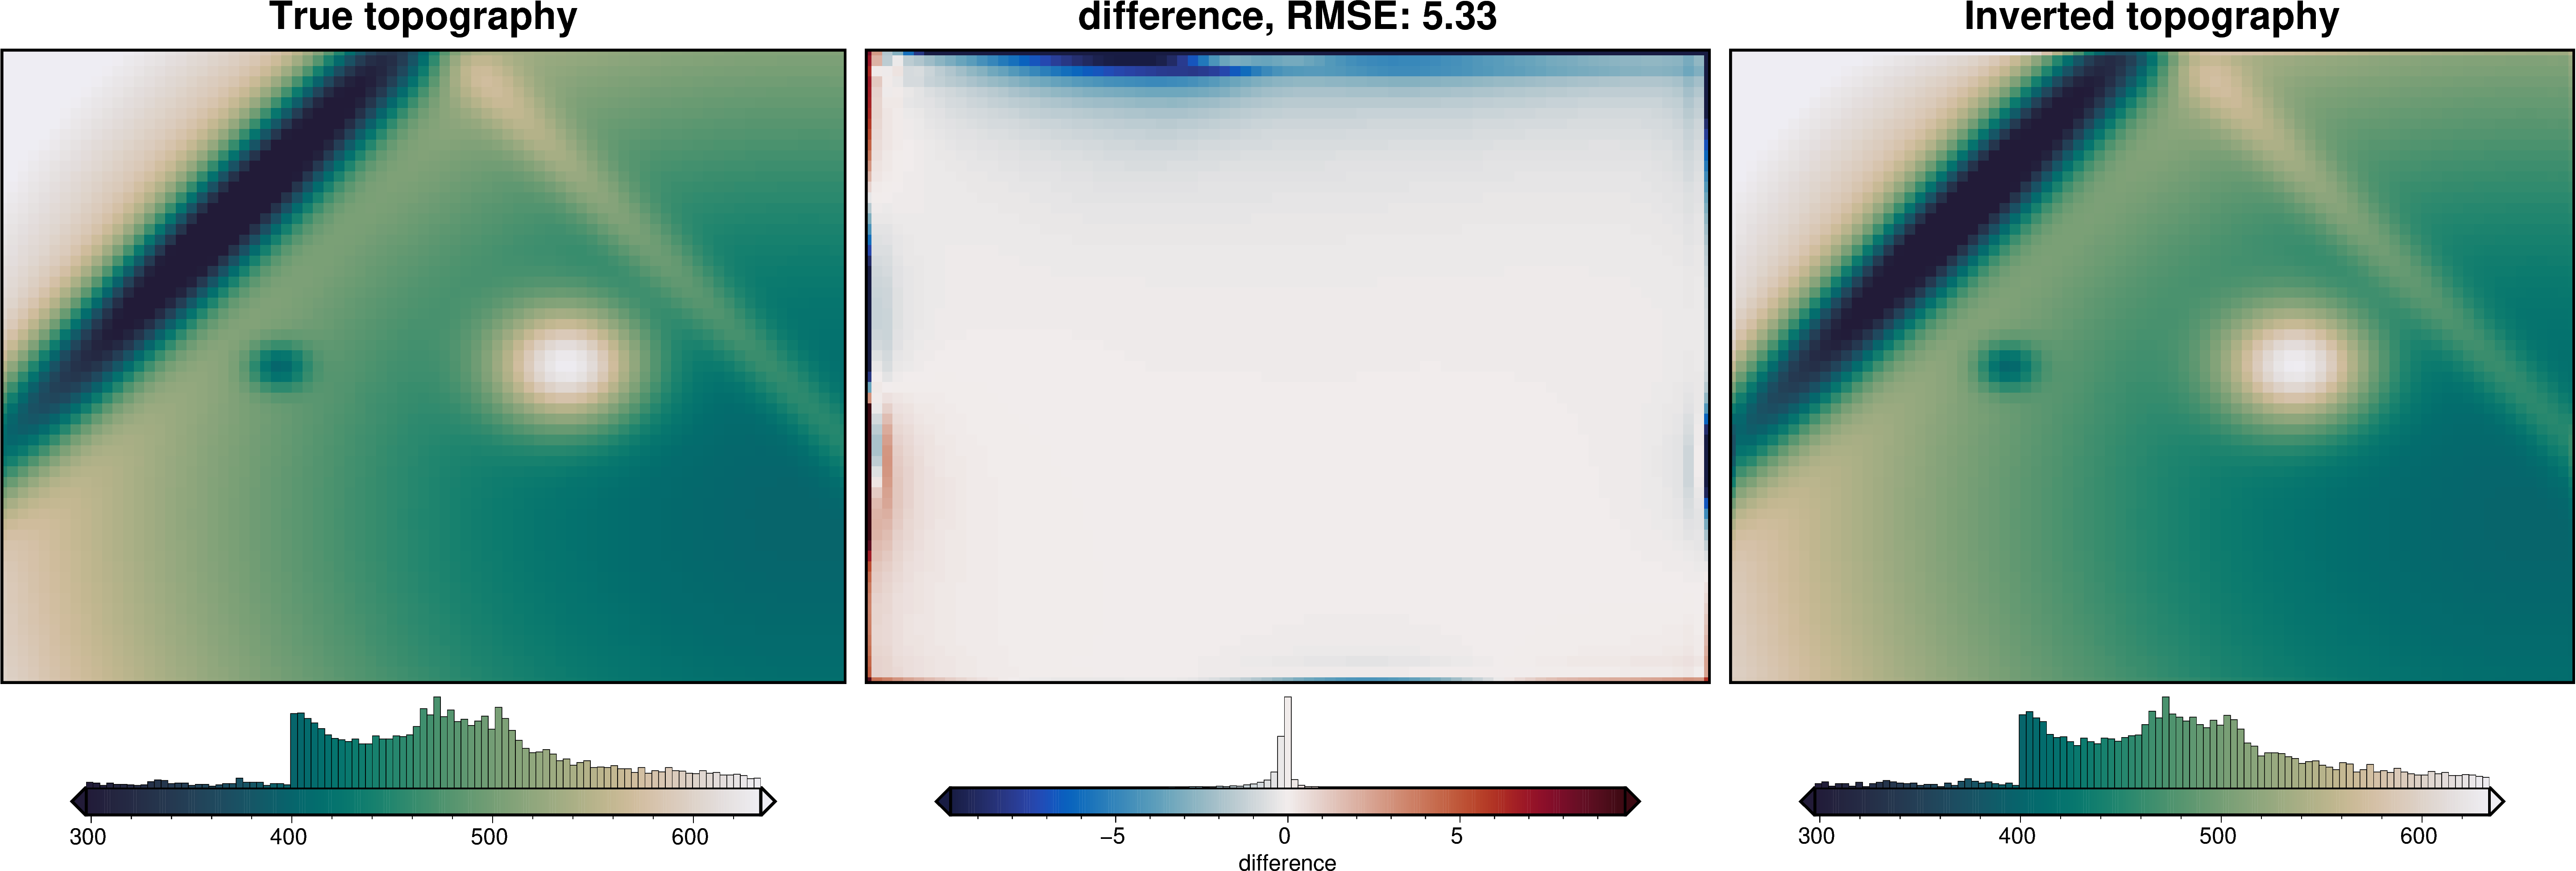

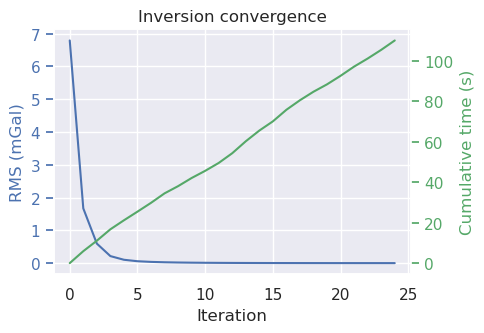

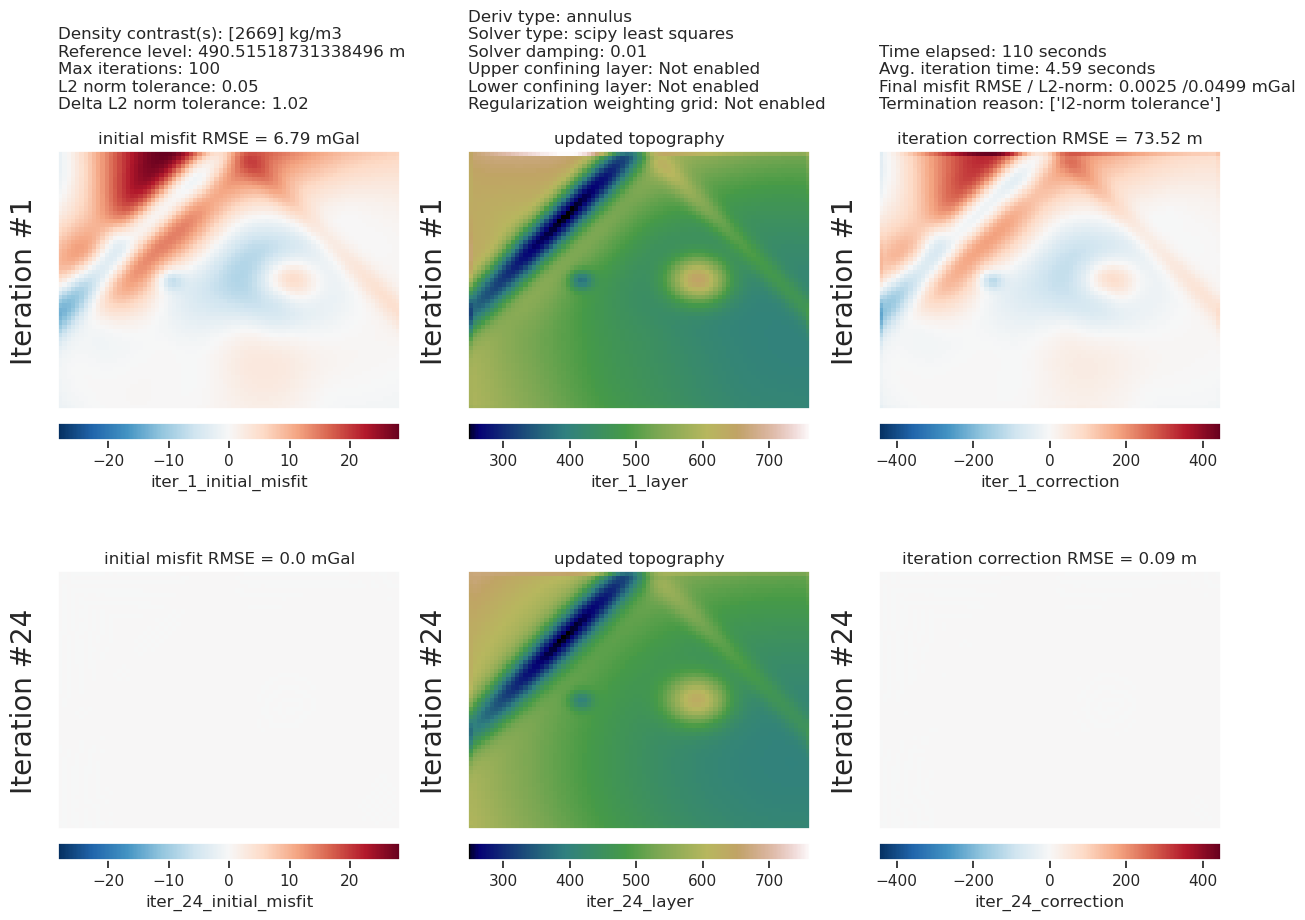

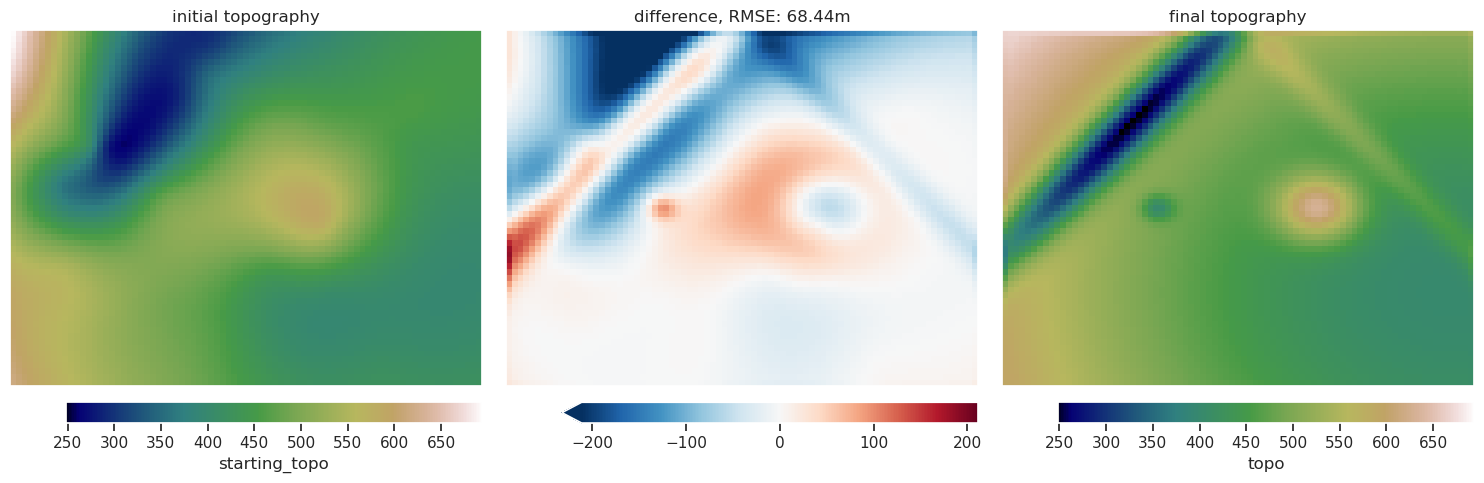

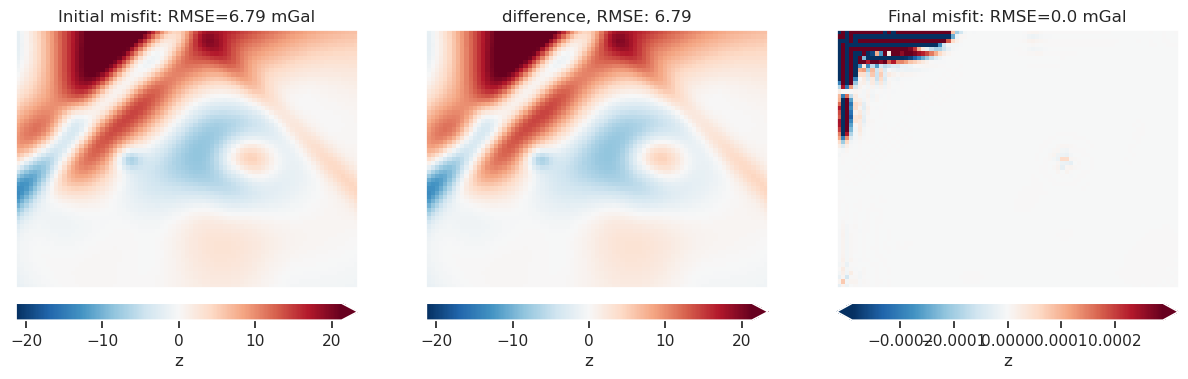

In [17]:
plotting.plot_convergence(
    grav_results,
    iter_times=parameters["Iteration times"],
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    # diff_lims=(-20, 20),
)